In [7]:
import pandas as pd
from ftplib import FTP
import os

In [35]:
#read in supplementary table
drugInfo = pd.read_csv("Drug_Info_Supp_Table.csv")
drugInfo["Drug"] = drugInfo["Drug"].str.strip()

#group all drugs by their type and turn into dictionary
drugTypes = drugInfo.groupby("Type")["Drug"].apply(list).to_dict()
print(drugTypes)

{'BET inhibitor': ['(+)-JQ-1', 'Bromosporine', 'Molibresib', 'Apabetalone'], 'Chemo drug': ['5-Azacytidine', 'Decitabine', "5-Fluoro-2'-deoxycytidine", 'Gemcitabine', 'Methotrexate', 'Actinomycin D', '5-Fluorouracil', 'Pemetrexed', 'Cisplatin', 'Carboplatin', 'Oxaliplatin', 'Doxorubicin', 'Cyclophosphamide'], 'E3 ligase ligands': ['VHL ligand 1', 'Nutlin-3', 'Serdemetan', 'VH298'], 'HDAC inhibitor': ['Entinostat', 'Mocetinostat', 'Romidepsin', 'Tacedinaline', 'Tucidinostat', 'Domatinostat', 'Pracinostat', 'Quisinostat', 'Vorinostat', 'AR-42', 'Belinostat', 'Citarinostat', 'Fimepinostat', 'Ricolinostat', 'Panobinostat', 'Givinostat', 'Tasquinimod', 'Nexturastat A', 'ACY738', 'Tubastatin A', 'Trichostatin-A', 'PCI-34051', 'ACY775', 'CHDI00465983', 'CHDI00390576', 'TMP195', 'TMP269', 'LMK235'], 'HSP90 inhibitor': ['Geldanamycin', 'Tanespimycin'], 'Hormone-like': ['Prednisone'], 'IMiD': ['Thalidomide', 'Iberdomide', 'Lenalidomide', 'Pomalidomide'], 'Immunosuppressor': ['Cyclosporin A'], 'K

In [ ]:
# make a table with all mean intensity values for all of the drugs
allDrugs = drugInfo["Drug"].to_list()
combined = pd.DataFrame(columns=["gene"])

# set up FTP 
ftp = FTP("massive-ftp.ucsd.edu")
ftp.login()
ftp.cwd("/v06/MSV000093659/other/Dose response data - Jurkat proteome")

for drug in allDrugs:
    # make a string with the drug name + _ALL.txt 
    drugFileName = f"{drug}_ALL.txt"

    # check if the file already exists locally (already downloaded it)
    if not os.path.exists(drugFileName):

        # if it doesn't already exist, use FTP to get that file from the server
        drugPath = f"{drug}/TXTs_Classified"
        ftp.cwd(drugPath)
        
        # download/write the file in binary mode
        with open(drugFileName, "wb") as file:
        # download the file "RETR fileName"
            ftp.retrbinary(f"RETR {drugFileName}", file.write)
        
        # move back to the Jurkat proteome directory
        ftp.cwd("../../")

    # load the file as a dataframe
    drugData = pd.read_csv(drugFileName, delimiter = "\t") 

    # select the gene and mean intensity columns  
    meanData = drugData[["gene", "Mean_Intensity"]]
    # rename mean intensity column to include the name of the drug
    renamedData = meanData.rename(columns = {"Mean_Intensity":f"{drug}_Mean_Intensity"})
    # add both of those columns to a combined dataframe (Created before the for loop)
    combined = pd.merge(combined, renamedData, how = "outer", on = "gene")

ftp.quit()
combined.set_index("gene")
combined.head()
combined.to_csv("Mean_Intensity_Matrix_All_Drugs.csv", index = False)

In [ ]:
# get cosine similarity matrix just for 2 drugs
import numpy
import sklearn 
from sklearn.metrics.pairwise import euclidean_distances

# create a cosine similarity metric for just comparing 2 drugs
meanIntensityMatrix = pd.read_csv("Mean_Intensity_Matrix_All_Drugs.csv").fillna(0)

# pull drug 1 and drug 2 (columns 1 and 2), which will be series
drug1 = meanIntensityMatrix.iloc[:,1] # column 0 is the gene names!
drug2 = meanIntensityMatrix.iloc[:,2] 
# print(f"drug 1:\n{drug1.head()}")
# print(f"drug 2:\n{drug2.head()}")

# convert the series to numpy arrays (use .to_numpy()) 
drug1 = drug1.to_numpy().reshape(1, -1) # reshape to be 2d vectors of rows, not 1d arrays
drug2 = drug2.to_numpy().reshape(1, -1) # 1 row (drug), infer number of columns (# of genes)
# plug those into the cosine_similarity function
euc_similarity_val = euclidean_distances(drug1, drug2)
print(euc_similarity_val)


[[4.74389368e+10]]


In [86]:
# create cosine similarity matrix for mean intensity
import numpy
import sklearn 
from sklearn.metrics.pairwise import cosine_similarity

# create a cosine similarity metric for just comparing 2 drugs
meanIntensityMatrix = pd.read_csv("Mean_Intensity_Matrix_All_Drugs.csv", index_col = 0).fillna(0)
# make column names just the drug name (remove _Mean_Intensity suffix!)
meanIntensityMatrix.columns = meanIntensityMatrix.columns.str.removesuffix("_Mean_Intensity")

# transpose data so drugs become rows instead of columns
transposedData = meanIntensityMatrix.transpose()
# save drug names index column for after
drugNames = transposedData.index

# plug transposed data into cosine_similarity function
cosineSimilarityMatrix = cosine_similarity(transposedData)
# convert to a dataframe and make row and column labels be the drug names
cosineSimilarityMatrix = pd.DataFrame(cosineSimilarityMatrix, columns = drugNames, index = drugNames)
cosineSimilarityMatrix.to_csv("Cosine_Similarity_Matrix.csv")


In [ ]:
# create euclidean similarity matrix for mean intensity
import numpy
import sklearn 
from sklearn.metrics.pairwise import euclidean_distances

# create a cosine similarity metric for just comparing 2 drugs
meanIntensityMatrix = pd.read_csv("Mean_Intensity_Matrix_All_Drugs.csv", index_col = 0).fillna(0)
# make column names just the drug name (remove _Mean_Intensity suffix!)
meanIntensityMatrix.columns = meanIntensityMatrix.columns.str.removesuffix("_Mean_Intensity")

# transpose data so drugs become rows instead of columns
transposedData = meanIntensityMatrix.transpose()
# save drug names index column for after
drugNames = transposedData.index

# get euclidean distances then convert to similarities 
eucDistancesMatrix = euclidean_distances(transposedData)
eucSimilarityMatrix = 1 / (1 + eucDistancesMatrix)

# convert to a dataframe and make row and column labels be the drug names
eucSimilarityMatrix = pd.DataFrame(eucSimilarityMatrix, columns = drugNames, index = drugNames)
eucSimilarityMatrix.to_csv("Euc_Similarity_Matrix.csv")


In [ ]:
# plot overall euc similarity distribution
import seaborn as sns
import matplotlib.pyplot as plt

# get only the lower triangle from the cosine matrix
bottom_diag = numpy.diagonal(eucSimilarityMatrix, offset = -1)
print(bottom_diag)

# plot the distribution
sns.histplot(bottom_diag, kde = True)
plt.xlabel("Euclidean Similarity")
plt.title("Euclidean Similarity Between Drugs")
plt.show()

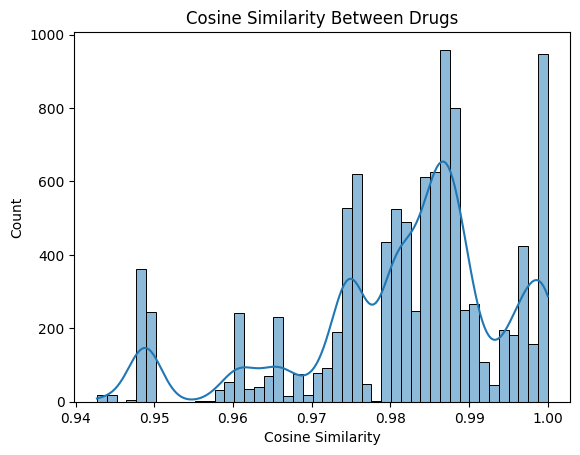

In [ ]:
# plot overall cosine distribution

import seaborn as sns
import matplotlib.pyplot as plt

cosineArray = cosineSimilarityMatrix.to_numpy()
# get the indices of the lower triangle in the array
bottomDiagIndices = numpy.tril_indices_from(cosineArray, k = -1)
# use indices to get values of the lower triangle in the array
bottomDiagVals = cosineArray[bottomDiagIndices]

# plot the distribution
sns.histplot(bottomDiagVals, kde = True)
plt.xlabel("Cosine Similarity")
plt.title("Cosine Similarity Between Drugs")
plt.show()


Type: BET inhibitor
Drugs:
	['(+)-JQ-1', 'Bromosporine', 'Molibresib', 'Apabetalone']


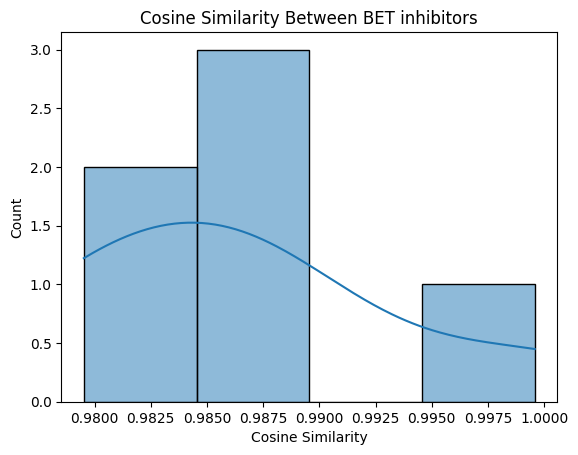

Type: Chemo drug
Drugs:
	['5-Azacytidine', 'Decitabine', "5-Fluoro-2'-deoxycytidine", 'Gemcitabine', 'Methotrexate', 'Actinomycin D', '5-Fluorouracil', 'Pemetrexed', 'Cisplatin', 'Carboplatin', 'Oxaliplatin', 'Doxorubicin', 'Cyclophosphamide']


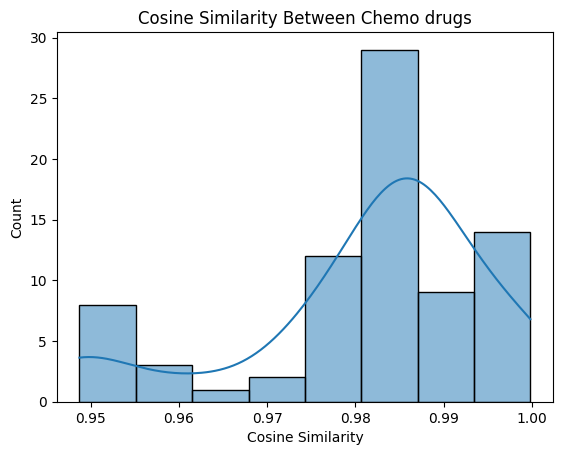

Type: E3 ligase ligands
Drugs:
	['VHL ligand 1', 'Nutlin-3', 'Serdemetan', 'VH298']


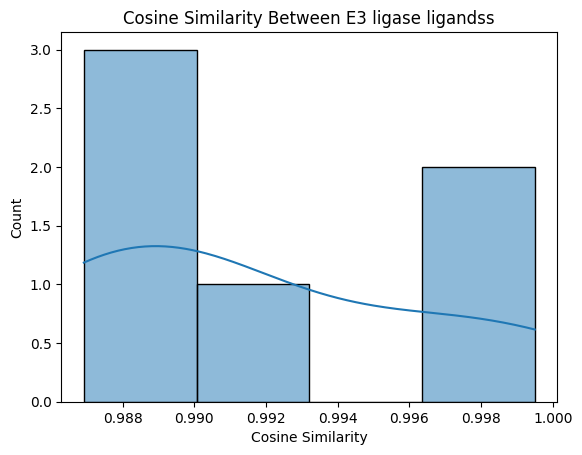

Type: HDAC inhibitor
Drugs:
	['Entinostat', 'Mocetinostat', 'Romidepsin', 'Tacedinaline', 'Tucidinostat', 'Domatinostat', 'Pracinostat', 'Quisinostat', 'Vorinostat', 'AR-42', 'Belinostat', 'Citarinostat', 'Fimepinostat', 'Ricolinostat', 'Panobinostat', 'Givinostat', 'Tasquinimod', 'Nexturastat A', 'ACY738', 'Tubastatin A', 'Trichostatin-A', 'PCI-34051', 'ACY775', 'CHDI00465983', 'CHDI00390576', 'TMP195', 'TMP269', 'LMK235']


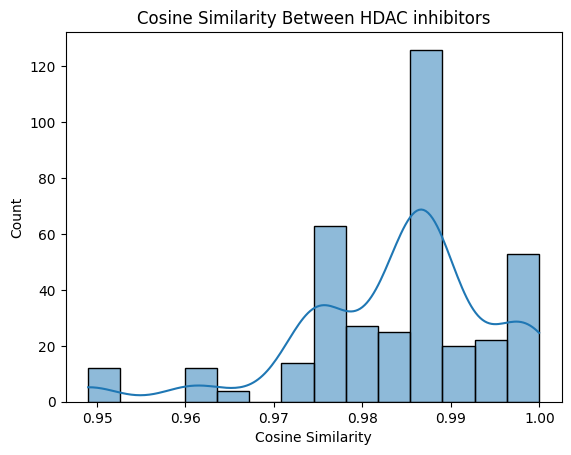

Type: HSP90 inhibitor
Drugs:
	['Geldanamycin', 'Tanespimycin']


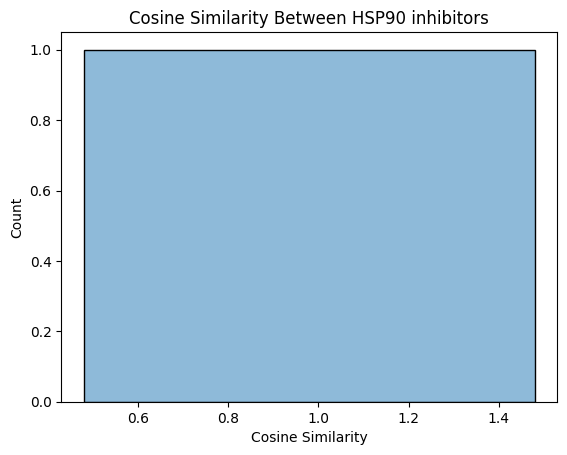

Type: Hormone-like
Drugs:
	['Prednisone']


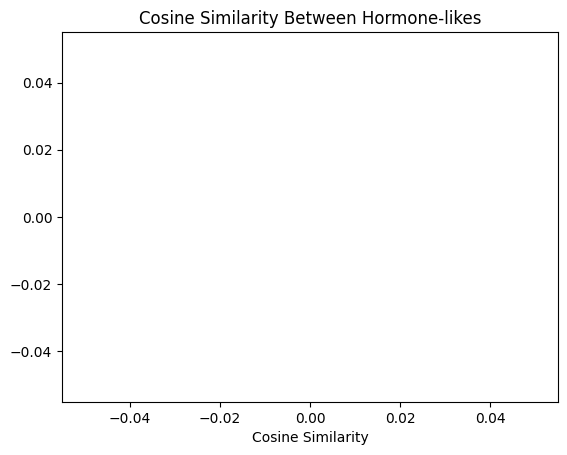

Type: IMiD
Drugs:
	['Thalidomide', 'Iberdomide', 'Lenalidomide', 'Pomalidomide']


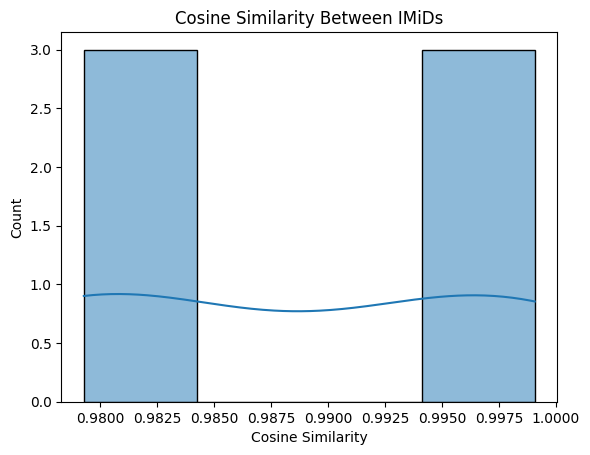

Type: Immunosuppressor
Drugs:
	['Cyclosporin A']


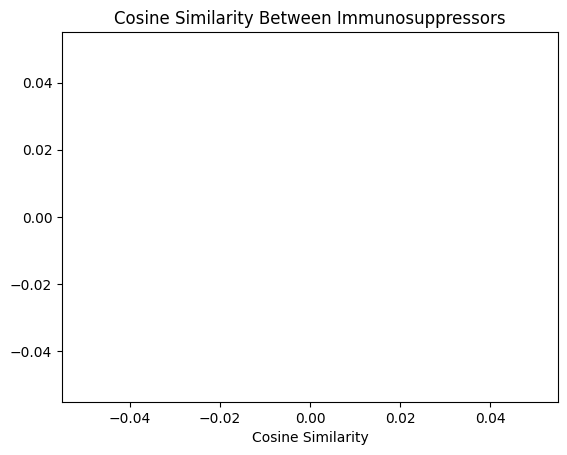

Type: Kinase inhibitor
Drugs:
	['AZD-6482', 'AZD-8186', 'Copanlisib', 'Dactolisib', 'BGT-226', 'Buparlisib', 'Alpelisib', 'Idelalisib', 'Apitolisib', 'GSK-1059615', 'Omipalisib', 'GSK-2636771', 'PF-04691502', 'TG-100-115', 'Pilaralisib', 'Voxtalisib', 'AZD-8055', 'Onatasertib', 'Everolimus', 'GDC-0349', 'Rapamycin', 'Temsirolimus', 'AZD-5438', 'SNS-032', 'Seliciclib', 'HMN-214', 'Alvocidib', 'Ribociclib', 'Rigosertib', 'Riviciclib', 'Palbociclib', 'PHA-793887', 'Milciclib', 'R-547', 'RGB-286638', 'Dinaciclib', 'Zotiraciclib', 'Cerdulatinib', 'Fostamatinib (Free Base)', 'Fostamatinib', 'TAK-659', 'Abemaciclib', 'Brigatinib', 'Crizotinib', 'Dabrafenib', 'Dasatinib', 'Nintedanib', 'Sunitinib', 'Staurosporine', 'Tofacitinib', 'Decernotinib', 'Baricitinib', 'Binimetinib', 'Selumetinib', 'Ravoxertinib', 'Trametinib', 'Ulixertinib', 'AMG-900', 'MK-5108', 'MLN-8054', 'SNS-314']


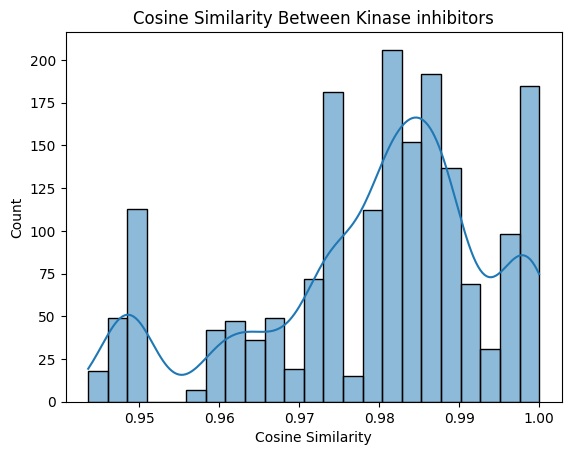

Type: MAOi
Drugs:
	['Tranylcypromine']


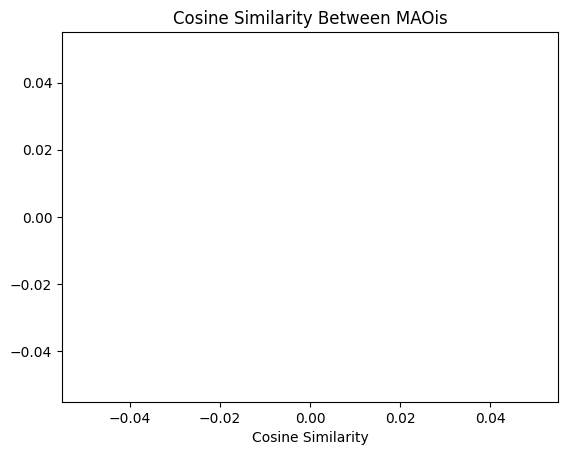

Type: Methyltransferase inhibitor
Drugs:
	['GSK2879552', 'Iadademstat', 'Pinometostat', 'Tazemetostat', 'Pemrametostat', 'Lirametostat', 'Onametostat']


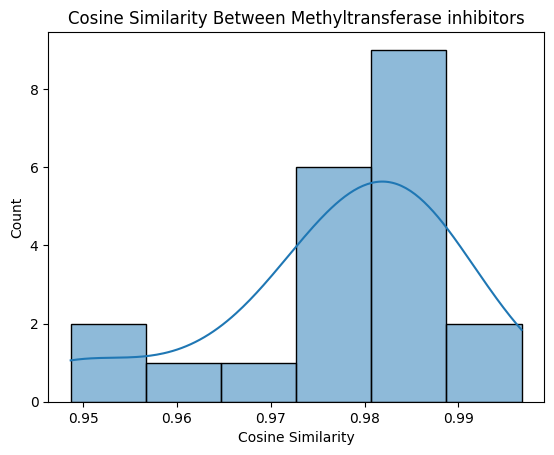

Type: Mitotic inhibitor
Drugs:
	['Paclitaxel', 'CHM-1', 'Nocodazole', 'Colchicine', 'Vincristine']


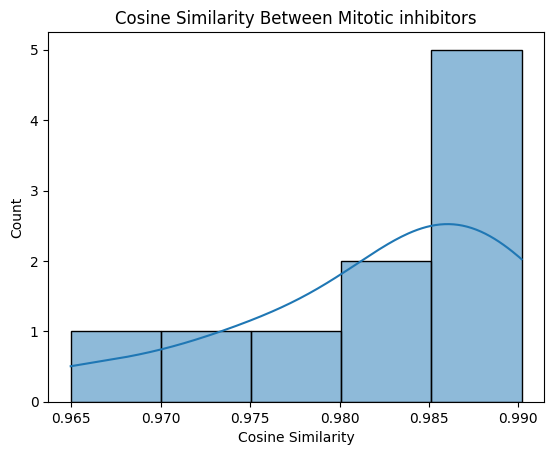

Type: NFAT activation inhibitor
Drugs:
	['NFAT activation inhibitor III']


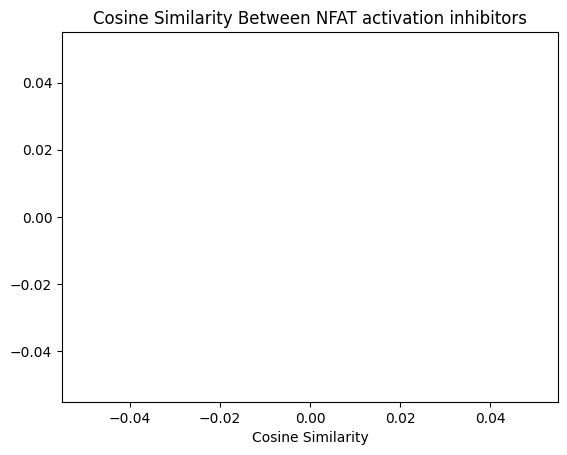

Type: PARP inhibitor
Drugs:
	['PJ34', 'Olaparib', 'Talazoparib', 'Rucaparib', 'Niraparib', 'Veliparib']


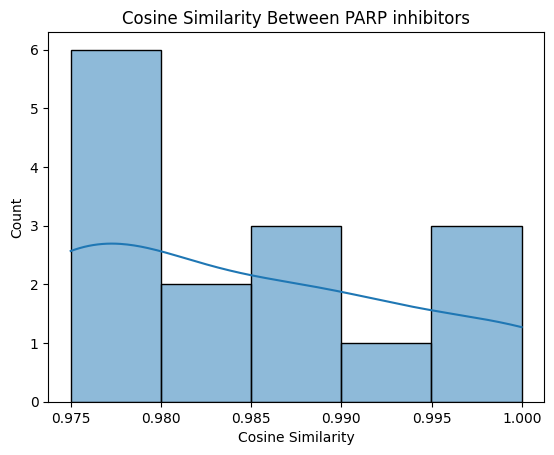

Type: Proteasome inhibitor
Drugs:
	['Ixazomib', 'MG-132', 'Carfilzomib', 'Bortezomib']


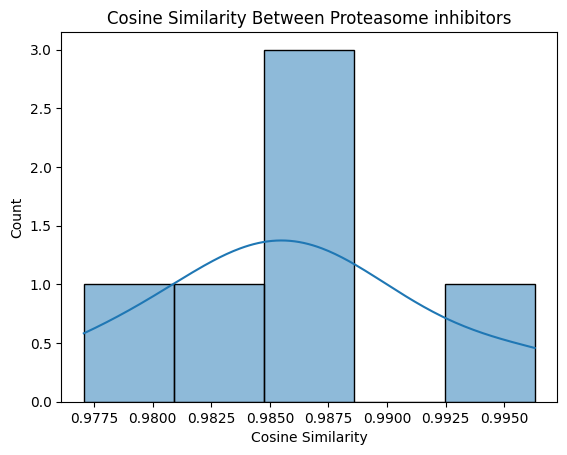

Type: SIRT inhibitor
Drugs:
	['Selisistat', 'SRT2104']


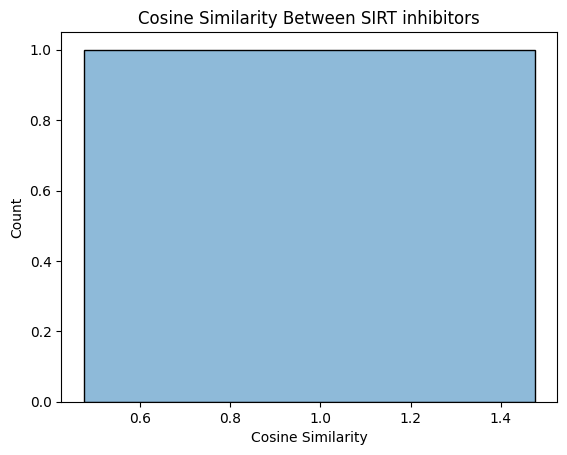

In [96]:
# plot distributions for each drug subtype 
for type, drugNames in drugTypes.items():
    print(f"Type: {type}\nDrugs:\n\t{drugNames}")

    # get the sub-matrix of drugs for this type 
    subTypeMatrix = cosineSimilarityMatrix.loc[drugNames, drugNames]
    # convert submatrix to a numpy array
    subArray = subTypeMatrix.to_numpy()
    # get indices of the lower triangle
    subBottomIndices = numpy.tril_indices_from(subArray, k = -1)
    # use indices to get values of the lower triangle
    subBottomVals = subArray[subBottomIndices]

    # plot the distribution
    sns.histplot(subBottomVals, kde = True)
    plt.xlabel("Cosine Similarity")
    plt.title(f"Cosine Similarity Between {type}s")
    plt.show()
    

In [ ]:
# create cosine similarity matrix for ic50
import numpy
import sklearn 
from sklearn.metrics.pairwise import cosine_similarity

# create a cosine similarity metric for just comparing 2 drugs
meanIntensityMatrix = pd.read_csv("ic50_matrix.csv", index_col = 0).fillna(0)
# transpose data so drugs become rows instead of columns
transposedData = meanIntensityMatrix.transpose()

# plug those into the cosine_similarity function
cosineSimilarityMatrix = cosine_similarity(transposedData)
# convert to a dataframe
cosineSimilarityMatrix = pd.DataFrame(cosineSimilarityMatrix)
cosineSimilarityMatrix.to_csv("Cosine_Similarity_Matrix_ic50.csv", index = False)

In [ ]:
# make separate files for mean intensity values based on drug types 

# get combined matrix of values and rename columns to just be the drug names
meanIntensityMatrix = combined
meanIntensityMatrix.columns = meanIntensityMatrix.columns.str.removesuffix("_Mean_Intensity")

# make empty dict for dataframes by type
# keys: drug types, values: dfs of mean intensity vals for drugs in that type
meansByDrugType = {}

# loop through the dictionary of types and drugs
for type, drugNames in drugTypes.items():
    # select columns in the combined matrix for all the drugs in that type
    typeSubset = meanIntensityMatrix[drugNames]
    # save those columns to the dict of types/values
    meansByDrugType[type] = typeSubset

# # print out meansByDrugType dictionary:
# for type, df in meansByDrugType.items():
#     print(f"type: {type}\n{df.head()}")

# save the df for each type as a csv 
for type, df in meansByDrugType.items():
    df.to_csv(f"Mean_Intensity_Matrix_{type}.csv", index = False)


# make separate files for ic50 values based on drug types
# OR, use the table from salma —> go thru the dict by drug type, select all the columns for the drugs in that type and
    # save them in a new data frame with the name of that drug type. 

# get combined matrix of values
ic50Matrix = pd.read_csv("ic50_matrix.csv")

# make empty dict for dataframes by type
# keys: drug types, values: dfs of ic50 vals for drugs in that type
ic50sByDrugType = {}

#read in supplementary table
# drugInfo = pd.read_csv("Drug_Info_Supp_Table.csv")
drugInfoWithUnderscores = drugInfo
drugInfoWithUnderscores["Drug"] = drugInfo["Drug"].str.replace(' ', '_')

#group all drugs by their type and turn into dictionary
drugTypesWithUnderscores = drugInfoWithUnderscores.groupby("Type")["Drug"].apply(list).to_dict()

# loop through the dictionary of types and drugs
for type, drugNames in drugTypesWithUnderscores.items():
    # select columns in the combined matrix for all the drugs in that type
    df = ic50Matrix[drugNames]
    # save those columns to the dict of types/values
    ic50sByDrugType[type] = df

# save the df for each type as a csv 
for type, df in ic50sByDrugType.items():
    df.to_csv(f"ic50_Matrix_{type}.csv", index = False)